## General settings for the Google Colab environment

In [ ]:
# Add a shortcut to 'NLP2 Project' folder to your drive to access it
from google.colab import drive
drive.mount('/content/drive')
# go to the path where the project is
%cd '/content/drive/MyDrive/NLP2 Project'

In [ ]:
pip install evaluate

In [ ]:
pip install transformers[torch]

In [ ]:
pip install accelerate -U

In [ ]:
pip install datasets

In [ ]:
pip install "ray[tune]"

## Implementations

In [5]:
import evaluate
import numpy as np
import os
from torch import cuda
import gc
import torch
import ray
from ray import tune, air
from ray.tune.schedulers import ASHAScheduler
import matplotlib.pyplot as plt
from datasets import (load_dataset, Dataset, DatasetDict)
import transformers
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer)
from data_operations import *

transformers.set_seed(42)

In [2]:
# load and explore the data
### Loading the data of only one difficulty level ==========================================================
# load and explore the data
train_data = read_input_data(medium_train_path)
val_data = read_input_data(medium_validation_path)
# concatenate train and validation data
concatenated_data = pd.concat([train_data, val_data], ignore_index=True)
# order data into paragraph pairs
concatenated_data_pars = generate_paragraph_pairs(train_data)
print_change_no_change_nr(concatenated_data_pars)
print("#sentence pairs - medium:", len(concatenated_data_pars))

(#Change, #No Change) = (15062, 11051)
Total nr of paragraph pairs:  26113
#sentence pairs - medium: 26113


## distilroberta-base / roberta-base

In [ ]:
# change variable for a different model
MODEL_CHECKPOINT = "distilroberta-base"

tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT, trust_remote_code=True)
get_maximum_seq_len(train_data, tokenizer)

### Data exploration

Maximum sequence length:  912
Average seq length:  56.638821055487725
Number of paragraphs exceeding the maximum length:  2
Maximum sequence length:  496
Average seq length:  54.63043822180035
Number of paragraphs exceeding the maximum length:  0
Maximum sequence length:  1031
Average seq length:  55.68948672566372
Number of paragraphs exceeding the maximum length:  2


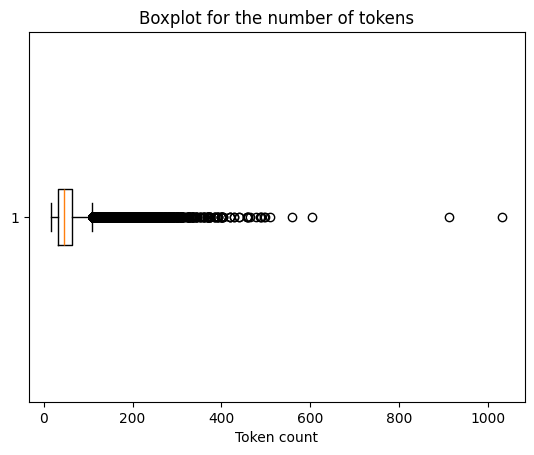

In [6]:
easy_train_data = read_input_data(easy_train_path)
medium_train_data = read_input_data(medium_train_path)
hard_train_data = read_input_data(hard_train_path)
easy_val_data = read_input_data(easy_validation_path)
medium_val_data = read_input_data(medium_validation_path)
hard_val_data = read_input_data(hard_validation_path)

# concatenate train and validation data
easy_concatenated_data = pd.concat([easy_train_data, easy_val_data], ignore_index=True)
medium_concatenated_data = pd.concat([medium_train_data, medium_val_data], ignore_index=True)
hard_concatenated_data = pd.concat([hard_train_data, hard_val_data], ignore_index=True)

seq_lens = get_maximum_seq_len(easy_concatenated_data, tokenizer)
seq_lens.extend(get_maximum_seq_len(medium_concatenated_data, tokenizer))
seq_lens.extend(get_maximum_seq_len(hard_concatenated_data, tokenizer))
plt.boxplot(seq_lens, vert=False)
plt.xlabel("Token count")
plt.title("Boxplot for the number of tokens")
plt.savefig("results/nr_tokens_boxplot.png")

In [7]:
# counting paragraph pairs
concatenated_train_data_pars = generate_paragraph_pairs(easy_concatenated_data)
print("easy:")
print_change_no_change_nr(concatenated_train_data_pars)
concatenated_train_data_pars = generate_paragraph_pairs(medium_concatenated_data)
print("medium:")
print_change_no_change_nr(concatenated_train_data_pars)
concatenated_train_data_pars = generate_paragraph_pairs(hard_concatenated_data)
print("hard:")
print_change_no_change_nr(concatenated_train_data_pars)

easy:
(#Change, #No Change) = (18121, 11363)
Total nr of paragraph pairs:  29484
medium:
(#Change, #No Change) = (18220, 13385)
Total nr of paragraph pairs:  31605
hard:
(#Change, #No Change) = (13231, 15019)
Total nr of paragraph pairs:  28250


### Implementation

In [ ]:
# check how does a tokenized sentence pair look after decoded
sent_pair = tokenizer(train_data['text'].iloc[1][0], train_data['text'].iloc[1][1],
                       padding="max_length", return_tensors="pt")
decoded = tokenizer.decode(sent_pair["input_ids"][0])
print(decoded)

In [ ]:
def encode_par_pairs(df):
    """
    Sentence pair tokenization.
    """
    return tokenizer(df["paragraph_1"], df["paragraph_2"], truncation=True, padding="max_length", return_tensors="pt")

# convert data to hugging face dataset
full_dataset = Dataset.from_pandas(concatenated_data_pars)
# tokenize paragraphs
tokenized_dataset = full_dataset.map(encode_par_pairs, batched=True)
print(tokenized_dataset)
# split data into taining, validation and test set
# first split into (train, val+test), then split (val+test) 1/2
train_valtest_set = tokenized_dataset.train_test_split(test_size=0.3, seed=42, shuffle=True)
val_test_set = train_valtest_set["test"].train_test_split(test_size=0.5, seed=42, shuffle=True)
data_splits = DatasetDict({
    "train": train_valtest_set["train"],
    "test": val_test_set["test"],
    "validation": val_test_set["train"]})
print(data_splits)

In [ ]:
device = 'cuda' if cuda.is_available() else 'cpu'
print('Device ', device)
torch.cuda.empty_cache()

# How to Train BERT with an Academic Budget: "it is better to use a smaller warmup proportion (2%)"
nr_warmup_steps = int(data_splits["train"].num_rows * 2/100)

# Methods used in training/validation/testing
def model_init():
    """
    Initialize a model of type AutoModelForSequenceClassification.
    """
    # there are two types of labels for change (0, 1), binary classification
    return AutoModelForSequenceClassification.from_pretrained(MODEL_CHECKPOINT, num_labels=2, trust_remote_code=True).to(device)


def compute_f1_score(eval_pred):
    """
    Compute F1 score for an input transformers.EvalPrediction.
    """
    f1_score = evaluate.load("f1")
    logits = eval_pred.predictions
    labels = eval_pred.label_ids
    # extraxt class with highest probability (softmax)
    predictions = np.argmax(logits, axis=-1)
    # garbage collections
    gc.collect()
    return f1_score.compute(predictions=predictions, references=labels, average="macro")


def set_f1_objective(metrics):
    """
    Return custom ojective.
    """
    return metrics["eval_f1"]

### Training and validation (hyperparameter search)

In [ ]:
training_args = TrainingArguments(
        output_dir='/train_output_distillroberta',
        report_to="none",
        do_train=True,
        do_eval=True,
        lr_scheduler_type='cosine',
        per_device_eval_batch_size=16,
        logging_strategy='epoch',
        logging_dir='/logs',
        warmup_steps=nr_warmup_steps,
        weight_decay=0.01,
        # eval_strategy='epoch', # google colab doesn't recognize eval_strategy
        # need to disable saving to not save ray checkpoints (full memory)
        save_strategy='epoch',
        save_total_limit=2,
        load_best_model_at_end=True,
        evaluation_strategy='epoch',
        fp16=cuda.is_available(),
        metric_for_best_model="eval_f1",
        seed=42,
)


trainer = Trainer(
    # model doesn't need to be set if model_init is set
    # model=model,
    args=training_args,
    # whole dataset can be passed, training ignores columns like paragraph_1
    train_dataset=data_splits["train"],
    eval_dataset=data_splits["validation"],
    model_init=model_init,
    compute_metrics=compute_f1_score,
)

hp_space = {
    "learning_rate": tune.grid_search([1e-5, 2e-5, 3e-5]),
    "per_device_train_batch_size": tune.grid_search([16, 32]),
    "num_train_epochs": tune.grid_search([1, 2, 3]),
}

asha_scheduler = ASHAScheduler(
    time_attr='epoch',
    metric='eval_f1',
    mode='max',
    # set higher than expected epochs
    max_t=4,
    grace_period=1,
    # removes 33% of the models
    reduction_factor=4,
)

# Run Hyperparameter Search and save best trial
best_trial = trainer.hyperparameter_search(
    direction="maximize",
    backend="ray",
    # saving checkpoints fill the drive
    # keep_checkpoints_num=1,
    # checkpoint_score_attr="training_iteration",
    checkpoint_config=air.CheckpointConfig(
        checkpoint_at_end=False,
        checkpoint_frequency=0,
        num_to_keep=1,
    ),
    raise_on_failed_trial=False,
    hp_space=lambda _: hp_space,
    resources_per_trial={
            "cpu": 2,
            "gpu": 1
        },
    # according to https://cloud.google.com/bigquery/docs/hp-tuning-overview
    # total number of trials should be at least 10 * num_hyperparameters
    # but we have an exact number of hyperparameters, so we can set n_trials to 1
    n_trials=1,
    compute_objective=set_f1_objective,
    scheduler=asha_scheduler,
    # verbose=0,
)

In [ ]:
best_trial

### Testing

In [ ]:
model = model_init()

training_args = TrainingArguments(
        output_dir='/train_output_distillroberta',
        report_to="none",
        do_train=True,
        do_eval=True,
        lr_scheduler_type='cosine',
        per_device_eval_batch_size=16,
        logging_strategy='epoch',
        logging_dir='/logs',
        warmup_steps=nr_warmup_steps,
        weight_decay=0.01,
        # eval_strategy='epoch', # google colab doesn't recognize eval_strategy
        # need to disable saving to not save ray checkpoints (full memory)
        save_total_limit=2,
        evaluation_strategy='epoch',
        fp16=cuda.is_available(),
        # tuned hyperparameters
        learning_rate=1e-05,
        per_device_train_batch_size=16,
        num_train_epochs=3,
        seed=42,
)


trainer = Trainer(
    # model doesn't need to be set if model_init is set
    model=model,
    args=training_args,
    # whole dataset can be passed, training ignores columns like paragraph_1
    train_dataset=data_splits["train"],
    eval_dataset=data_splits["validation"],
    # model_init=model_init,
    compute_metrics=compute_f1_score,
)

In [ ]:
# train the model
trainer.train()

In [ ]:
# save best model
trainer.save_model("./results/medium_best_model_distillroberta")

In [ ]:
trainer.evaluate()

In [ ]:
# test the model
trainer.predict(data_splits["test"])

#### Analyze results

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, data_splits["test"], labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()